Importing Data...
Performing Quality Control...
Performing Clustering...


/opt/homebrew/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Plotting UMAP...


/opt/homebrew/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/homebrew/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/opt/homebrew/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/opt/homebrew/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/homebrew/lib/python3.10/

Frequency Analysis...
   group    sample leiden  orig.ident  nCount_RNA  nFeature_RNA  total_cells  \
0    CON  CON_DS2U     IN         418         418           418        20401   
24    DS    DS_DSP     IN        3879        3879          3879        14225   
6    CON    CON_H9     IN        1523        1523          1523        20401   
18    DS   DS_2DS3     IN        4272        4272          4272        14225   
12   CON   CON_IMR     IN        1514        1514          1514        20401   
1    CON  CON_DS2U    IPC         674         674           674        20401   
25    DS    DS_DSP    IPC          58          58            58        14225   
7    CON    CON_H9    IPC         214         214           214        20401   
19    DS   DS_2DS3    IPC         172         172           172        14225   
13   CON   CON_IMR    IPC         586         586           586        20401   
26    DS    DS_DSP    MGE         755         755           755        14225   
20    DS   DS_2DS3

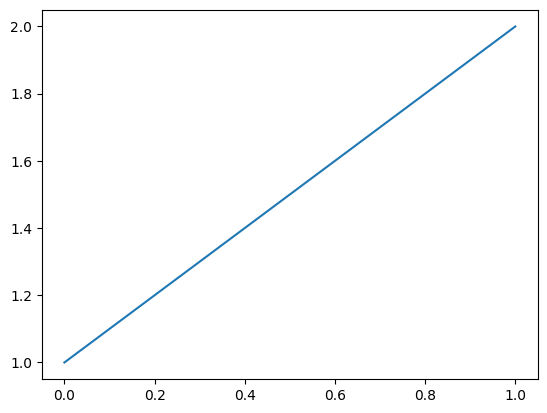

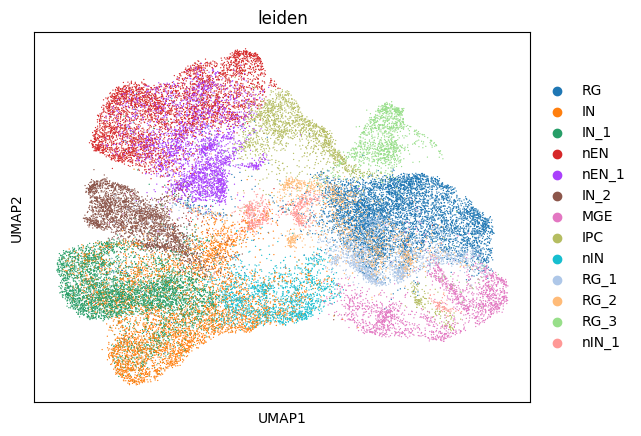

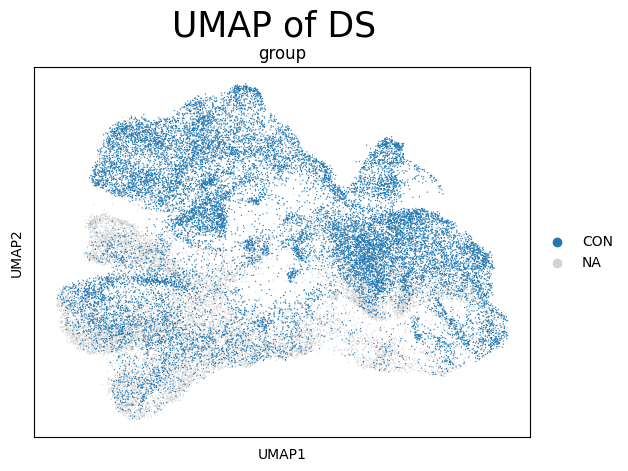

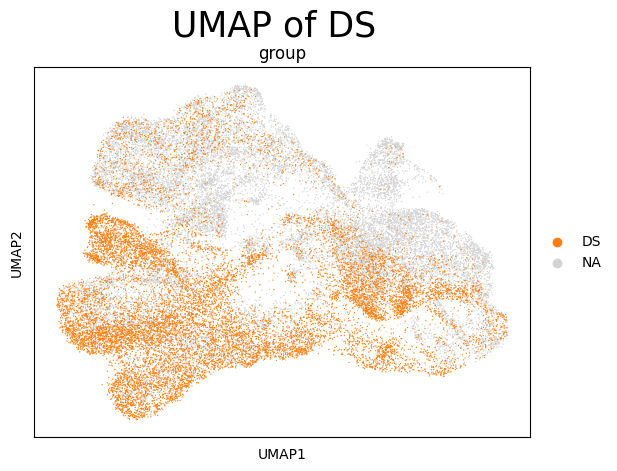

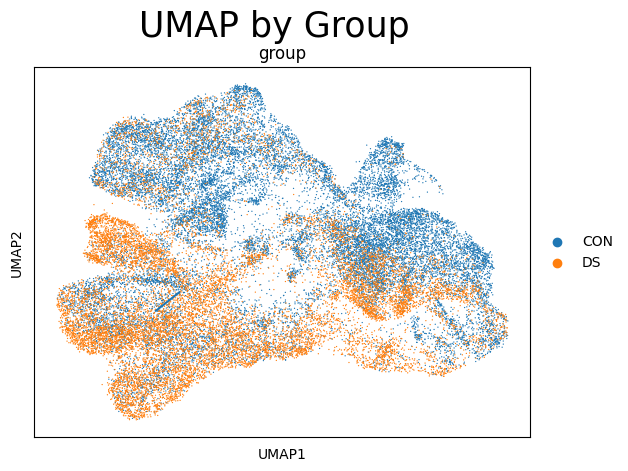

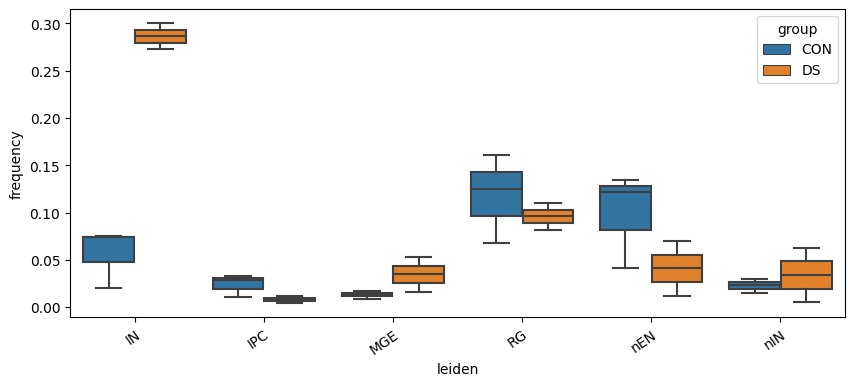

In [1]:
from itertools import groupby
from json import load
import pandas as pd
import scanpy as sc
import numpy as np
import sys
import modules.classifyClusters.classifyClusters as classify
import os
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns


class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'    

####################################################################################################
# Import Data 
####################################################################################################
print(bcolors.FAIL + "Importing Data..." + bcolors.ENDC)
adata = sc.read("./output/savedDataClustersFinal.h5ad")
adata.var_names_make_unique()
showPlots = False

####################################################################################################
# QC Calculations 
####################################################################################################
print(bcolors.FAIL + "Performing Quality Control..." + bcolors.ENDC)
adata.var['mt'] = adata.var_names.str.startswith('MT-')

riboURL = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
riboGenes = pd.read_table(riboURL, skiprows=2, header = None)
adata.var['ribo'] = adata.var_names.isin(riboGenes[0].values)

sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', "ribo"], percent_top=None, log1p=False, inplace=True)

adata = adata[adata.obs.pct_counts_mt < 10, :]
adata = adata[adata.obs.n_genes_by_counts > 1000, :]

####################################################################################################
# Clustering 
####################################################################################################
print(bcolors.FAIL + "Performing Clustering..." + bcolors.ENDC)
sc.pp.normalize_total(adata, target_sum=10000)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

adata.var.at["OLIG2", "highly_variable"] = True

adata.raw = adata
adata = adata[:, adata.var.highly_variable]

sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40) # n_neighbors=15 is default
sc.tl.umap(adata)

adataDS =  adata[adata.obs["group"] == "DS"]
adataCON =  adata[adata.obs["group"] == "CON"]

sc.external.pp.bbknn(adata, batch_key='sample')
sc.tl.umap(adata)

####################################################################################################
# Plot Umap
####################################################################################################
print(bcolors.FAIL + "Plotting UMAP..." + bcolors.ENDC)

with PdfPages('./Figures/Figure 1.pdf') as pdf:
    dummyPlot = plt.plot([1, 2])
    figureNum = plt.gcf().number

    sc.pl.umap(adata, color="leiden", show=showPlots)
    sc.pl.umap(adata, color='group', groups="CON", show=showPlots)
    plt.suptitle("UMAP of DS", y=1, fontsize=25)
    sc.pl.umap(adata, color='group', groups="DS", show=showPlots)
    plt.suptitle("UMAP of DS", y=1, fontsize=25)
    sc.pl.umap(adata, color='group', show=showPlots)
    plt.suptitle("UMAP by Group", y=1, fontsize=25)

    for fig in range(figureNum+1,  plt.gcf().number+1):
        pdf.savefig(figure=fig, bbox_inches='tight')

####################################################################################################
# Frequency Analysis 
####################################################################################################
print(bcolors.FAIL + "Frequency Analysis..." + bcolors.ENDC)
with PdfPages('./Figures/Frequency Analysis.pdf') as pdf:
    dummyPlot = plt.plot([1, 2])
    figureNum = plt.gcf().number

    ####################################################################################################
    # Grouped Frequency Analysis 
    ####################################################################################################
    leidenNames = list(adata.obs["leiden"])
    leidenNewNames = []

    for name in leidenNames:
        if "_" in name:
            newName = name.split("_")[0]
            leidenNewNames.append(newName)
        else:
            leidenNewNames.append(name)
    adata.obs["leiden"] = leidenNewNames

    ####################################################################################################
    # Grouped Frequency Analysis 
    ####################################################################################################
    num_tot_cells = adata.obs.groupby(['group']).count()
    num_tot_cells = dict(zip(num_tot_cells.index, num_tot_cells.nFeature_RNA))

    cell_type_counts = adata.obs.groupby(['group', 'sample','leiden']).count()
    cell_type_counts = cell_type_counts[cell_type_counts.sum(axis = 1) > 0].reset_index()
    cell_type_counts = cell_type_counts[cell_type_counts.columns[0:6]]

    cell_type_counts['total_cells'] = cell_type_counts.group.map(num_tot_cells).astype(int)

    cell_type_counts['frequency'] = cell_type_counts.nFeature_RNA / cell_type_counts.total_cells

    cell_type_counts = cell_type_counts.sort_values(by=['leiden'])
    print(cell_type_counts)
    
    plt.figure(figsize = (10,4))

    print(cell_type_counts)
    ax = sns.boxplot(data = cell_type_counts, x = 'leiden', y = 'frequency', hue = 'group')

    plt.xticks(rotation = 35, rotation_mode = 'anchor', ha = 'right')


    for fig in range(figureNum+1,  plt.gcf().number+1):
        pdf.savefig(figure=fig, bbox_inches='tight')

In [2]:
cell_type_counts

,group,sample,leiden,orig.ident,nCount_RNA,nFeature_RNA,total_cells,frequency
0,CON,CON_DS2U,IN,418,418,418,20401,0.020489
24,DS,DS_DSP,IN,3879,3879,3879,14225,0.272689
6,CON,CON_H9,IN,1523,1523,1523,20401,0.074653
18,DS,DS_2DS3,IN,4272,4272,4272,14225,0.300316
12,CON,CON_IMR,IN,1514,1514,1514,20401,0.074212
1,CON,CON_DS2U,IPC,674,674,674,20401,0.033038
25,DS,DS_DSP,IPC,58,58,58,14225,0.004077
7,CON,CON_H9,IPC,214,214,214,20401,0.010490
19,DS,DS_2DS3,IPC,172,172,172,14225,0.012091
13,CON,CON_IMR,IPC,586,586,586,20401,0.028724


In [7]:
cell_type_counts["frequency100"] = cell_type_counts["frequency"]*100
cell_type_counts

,group,sample,leiden,orig.ident,nCount_RNA,nFeature_RNA,total_cells,frequency,frequency100
0,CON,CON_DS2U,IN,418,418,418,20401,0.020489,2.048919
24,DS,DS_DSP,IN,3879,3879,3879,14225,0.272689,27.268893
6,CON,CON_H9,IN,1523,1523,1523,20401,0.074653,7.465320
18,DS,DS_2DS3,IN,4272,4272,4272,14225,0.300316,30.031634
12,CON,CON_IMR,IN,1514,1514,1514,20401,0.074212,7.421205
1,CON,CON_DS2U,IPC,674,674,674,20401,0.033038,3.303760
25,DS,DS_DSP,IPC,58,58,58,14225,0.004077,0.407733
7,CON,CON_H9,IPC,214,214,214,20401,0.010490,1.048968
19,DS,DS_2DS3,IPC,172,172,172,14225,0.012091,1.209139
13,CON,CON_IMR,IPC,586,586,586,20401,0.028724,2.872408


In [3]:
listClusters = list(dict.fromkeys(cell_type_counts["leiden"].to_list()))
listClusters

['IN', 'IPC', 'MGE', 'RG', 'nEN', 'nIN']

In [20]:
import numpy as np
import scipy.stats as stats

In [34]:
p_values = []
stadistic_values = []
for cluster in listClusters:
    clusterTest = cell_type_counts[cell_type_counts["leiden"]==cluster]
    clusterTest = clusterTest.sort_values(by=['sample'])
    groupCON = clusterTest[clusterTest["group"]=="CON"]["frequency100"].to_numpy()
    groupDS = clusterTest[clusterTest["group"]=="DS"]["frequency100"].to_numpy()
    results = stats.ttest_ind(a=groupCON, b=groupDS, equal_var=False)
    p_values += [results.pvalue] * 5
    stadistic_values += [results.statistic] * 5
cell_type_counts["p_values"] = p_values
cell_type_counts["stadistic_values"] = stadistic_values

In [35]:
cell_type_counts

,group,sample,leiden,orig.ident,nCount_RNA,nFeature_RNA,total_cells,frequency,frequency100,p_values,stadistic_values
0,CON,CON_DS2U,IN,418,418,418,20401,0.020489,2.048919,0.002097,-10.145579
24,DS,DS_DSP,IN,3879,3879,3879,14225,0.272689,27.268893,0.002097,-10.145579
6,CON,CON_H9,IN,1523,1523,1523,20401,0.074653,7.465320,0.002097,-10.145579
18,DS,DS_2DS3,IN,4272,4272,4272,14225,0.300316,30.031634,0.002097,-10.145579
12,CON,CON_IMR,IN,1514,1514,1514,20401,0.074212,7.421205,0.002097,-10.145579
1,CON,CON_DS2U,IPC,674,674,674,20401,0.033038,3.303760,0.141671,2.002955
25,DS,DS_DSP,IPC,58,58,58,14225,0.004077,0.407733,0.141671,2.002955
7,CON,CON_H9,IPC,214,214,214,20401,0.010490,1.048968,0.141671,2.002955
19,DS,DS_2DS3,IPC,172,172,172,14225,0.012091,1.209139,0.141671,2.002955
13,CON,CON_IMR,IPC,586,586,586,20401,0.028724,2.872408,0.141671,2.002955


In [36]:
cell_type_counts.to_csv("./Figures/Figure 1/Frequency Analysis.csv")

In [11]:
test = cell_type_counts[cell_type_counts["leiden"]=="IN"]
test = test.sort_values(by=['sample'])
groupCON = test[test["group"]=="CON"]["frequency100"].to_numpy()
groupDS = test[test["group"]=="DS"]["frequency100"].to_numpy()
test

,group,sample,leiden,orig.ident,nCount_RNA,nFeature_RNA,total_cells,frequency,frequency100
0,CON,CON_DS2U,IN,418,418,418,20401,0.020489,2.048919
6,CON,CON_H9,IN,1523,1523,1523,20401,0.074653,7.465320
12,CON,CON_IMR,IN,1514,1514,1514,20401,0.074212,7.421205
18,DS,DS_2DS3,IN,4272,4272,4272,14225,0.300316,30.031634
24,DS,DS_DSP,IN,3879,3879,3879,14225,0.272689,27.268893


In [14]:
print(np.var(groupCON), np.var(groupDS))

6.466755667990385 1.9081853589530524


In [15]:
6.466755667990385/1.9081853589530524

3.388955710014694

In [28]:
import scipy.stats as stats

stats.ttest_ind(a=groupCON, b=groupDS, equal_var=False)

Ttest_indResult(statistic=-10.145578819917134, pvalue=0.0020969727356853676)

In [29]:
statsResults = stats.ttest_ind(a=groupCON, b=groupDS, equal_var=True)

In [30]:
statsResults.pvalue

0.0028412650265162336

In [31]:
statsResults.statistic

-9.058911278063853